# DNN Model Training

This notebook achieves the following:

1. Prepares the generated training data for model training.
2. Trains various model architectures.
3. Plots training results to determine best model architecture. 
4. Saves best DNN model for testing. 

In [3]:
# import relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber, mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping, History
import matplotlib.pyplot as plt
from project_functions import save_data_to_csv
import os
import pickle

ModuleNotFoundError: No module named 'tensorflow'

# Raw Data

In [169]:
# import data from csv to dataframe
filename = "raw_training_data.csv"
df = pd.read_csv(filename)
display(df)

# split into input and target features
X = df[['distance_to_road_center', 'angle_from_straight_in_rads']].values
y = df['steering_angle'].values
r = df['reward'].values

# normalize rewards to [0, 1] range
norm_r = (r - np.min(r)) / (np.max(r) - np.min(r))

# Calculate weights based on normalized rewards
weights = np.where(r < 0, 1 / (1 - norm_r), 1 / (1 + norm_r))

Xtrain, Xval, ytrain, yval, wtrain, wval = train_test_split(X, y, weights, test_size=0.2, random_state=42)


,steering_angle,distance_to_road_center,angle_from_straight_in_rads,reward,total_reward
0,-2.017271,-1.449541,-1.197695,0.022491,-0.282823
1,-2.017271,-1.449541,-1.197695,0.022491,-0.282576
2,-2.017271,-1.449541,-1.197695,0.022491,-0.282330
3,-2.017271,-1.449541,-1.197695,0.022491,-0.282083
4,-2.017271,-1.449541,-1.197695,0.022279,-0.281837
...,...,...,...,...,...
124995,0.144081,0.147693,0.010285,-3.835282,-4.523919
124996,0.142465,0.148484,0.006000,-3.813875,-4.527890
124997,0.140811,0.149215,0.001745,-3.792289,-4.531838
124998,0.139120,0.149889,-0.002478,-3.770526,-4.535762


c:\Users\sophi\anaconda3\envs\ad_project\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app


## Base Model Training

Base Model Hyperparameters:
- Activation functions: ReLu
- Optimizer: Adam
    - Learning Rate: 0.001
- Batch Size = 32
- Loss Function: Huber Loss

In [170]:
# find optimal number of epochs using early stopping

# define base model with default Huber loss delta = 1.0
model = Sequential([
    Dense(64, activation='relu', input_shape=(Xtrain.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer for steering angle prediction
])

# compile with custom loss function
model.compile(loss=Huber(delta=1.0), optimizer=Adam(lr=0.001))

# define early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=5, mode='min', restore_best_weights=True)

# fit the model
history = model.fit(Xtrain, ytrain, sample_weight=wtrain, epochs=30, batch_size=32, validation_data = (Xval, yval, wval), callbacks = [early_stop])

Epoch 1/30
3125/3125 [==============================] - 4s 1ms/step - loss: 0.0263 - val_loss: 0.0021
Epoch 2/30
3125/3125 [==============================] - 2s 766us/step - loss: 5.1962e-04 - val_loss: 2.4100e-04
Epoch 3/30
3125/3125 [==============================] - 2s 708us/step - loss: 5.5770e-04 - val_loss: 1.5672e-04
Epoch 4/30
3125/3125 [==============================] - 2s 726us/step - loss: 3.8755e-04 - val_loss: 2.2672e-05
Epoch 5/30
3125/3125 [==============================] - 2s 690us/step - loss: 2.5710e-04 - val_loss: 1.3552e-04
Epoch 6/30
3125/3125 [==============================] - 2s 650us/step - loss: 1.8323e-04 - val_loss: 6.1668e-04
Epoch 7/30
3125/3125 [==============================] - 2s 693us/step - loss: 1.9857e-04 - val_loss: 4.7195e-05
Epoch 8/30
3125/3125 [==============================] - 2s 751us/step - loss: 1.3506e-04 - val_loss: 9.8655e-06
Epoch 9/30
3125/3125 [==============================] - 2s 693us/step - loss: 2.7123e-04 - val_loss: 1.5246e-05
Ep

In [171]:
# find best delta for loss function

# function to train and evaluate model with a given delta
def train_and_evaluate(delta, Xtrain, ytrain, wtrain, Xval, yval, wval):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(Xtrain.shape[1],)), 
        Dense(32, activation='relu'),
        Dense(1)
    ])

    model.compile(optimizer=Adam(learning_rate=0.001), loss=Huber(delta=delta), metrics=['mae', 'mse'])

    history = model.fit(Xtrain, ytrain, sample_weight=wtrain, epochs=early_stop.stopped_epoch, batch_size=32, validation_data=(Xval, yval, wval))

    # get validation MAE and MSE
    val_mae = history.history['val_mae'][-1]
    val_mse = history.history['val_mse'][-1]

    return val_mae, val_mse

# initialise delta value and step size
delta = 1.0
step_size = 0.1
best_delta = delta
best_val_mae = float('inf')
best_val_mse = float('inf')

# iterative search for optimal delta (10 iterations)
for i in range(10):
    val_mae, val_mse = train_and_evaluate(delta, Xtrain, ytrain, wtrain, Xval, yval, wval)

    # print current results
    print(f"Iteration {i+1}: delta = {delta}, val_mae = {val_mae}, val_mse = {val_mse}")

    # update best delta if current results are better
    if val_mae < best_val_mae and val_mse < best_val_mse: 
        best_delta = delta
        best_val_mae = val_mae
        best_val_mse = val_mse
    
    # adjust delta for next iteration 
    delta += step_size

print(f"Best delta: {best_delta}")
print(f"Best validation MAE: {best_val_mae}")
print(f"Best validation MSE: {best_val_mse}")

Epoch 1/12
3125/3125 [==============================] - 4s 1ms/step - loss: 0.0267 - mae: 0.0224 - mse: 0.0095 - val_loss: 9.4628e-04 - val_mae: 0.0166 - val_mse: 3.9362e-04
Epoch 2/12
3125/3125 [==============================] - 2s 780us/step - loss: 8.7165e-04 - mae: 0.0100 - mse: 3.2695e-04 - val_loss: 5.0341e-04 - val_mae: 0.0062 - val_mse: 1.1496e-04
Epoch 3/12
3125/3125 [==============================] - 2s 789us/step - loss: 5.2693e-04 - mae: 0.0089 - mse: 2.2218e-04 - val_loss: 3.0750e-04 - val_mae: 0.0058 - val_mse: 8.2185e-05
Epoch 4/12
3125/3125 [==============================] - 2s 781us/step - loss: 3.4809e-04 - mae: 0.0078 - mse: 1.4829e-04 - val_loss: 7.0597e-05 - val_mae: 0.0051 - val_mse: 4.4250e-05
Epoch 5/12
3125/3125 [==============================] - 2s 789us/step - loss: 3.5162e-04 - mae: 0.0077 - mse: 1.6933e-04 - val_loss: 5.1933e-05 - val_mae: 0.0031 - val_mse: 2.2418e-05
Epoch 6/12
3125/3125 [==============================] - 2s 756us/step - loss: 3.0285e-04 -

In [172]:
# evaluate base model 
base_model = Sequential([
        Dense(64, activation='relu', input_shape=(Xtrain.shape[1],)), 
        Dense(32, activation='relu'),
        Dense(1)
    ])

base_model.compile(optimizer=Adam(learning_rate=0.001), loss=Huber(delta=best_delta))

# initialise History object to save training history
history = History()

history = base_model.fit(Xtrain, ytrain, sample_weight=wtrain, epochs=early_stop.stopped_epoch, batch_size=32, validation_data=(Xval, yval, wval), callbacks=[history])

# create folder for models
if not os.path.exists("models"):
    os.makedirs("models")

# save model in models
base_model.save("models/base_dnn_model_raw_pd.h5")

# save model history in models
with open('models/base_dnn_model_raw_pd_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

# print results
base_train_hl = history.history["loss"][-1]
base_val_hl = history.history["val_loss"][-1]
print(f"Training Huber Loss: {base_train_hl}")
print(f"Validation Huber Loss: {base_val_hl}")

Epoch 1/12
3125/3125 [==============================] - 4s 1ms/step - loss: 0.0210 - val_loss: 0.0013
Epoch 2/12
3125/3125 [==============================] - 2s 762us/step - loss: 7.3117e-04 - val_loss: 0.0012
Epoch 3/12
3125/3125 [==============================] - 2s 651us/step - loss: 5.9045e-04 - val_loss: 9.3531e-04
Epoch 4/12
3125/3125 [==============================] - 2s 692us/step - loss: 4.5600e-04 - val_loss: 1.0606e-04
Epoch 5/12
3125/3125 [==============================] - 2s 709us/step - loss: 3.9195e-04 - val_loss: 8.3013e-05
Epoch 6/12
3125/3125 [==============================] - 2s 741us/step - loss: 3.0722e-04 - val_loss: 1.5809e-05
Epoch 7/12
3125/3125 [==============================] - 2s 735us/step - loss: 1.6639e-04 - val_loss: 5.8386e-06
Epoch 8/12
3125/3125 [==============================] - 2s 725us/step - loss: 1.9166e-04 - val_loss: 7.2212e-06
Epoch 9/12
3125/3125 [==============================] - 2s 695us/step - loss: 1.7678e-04 - val_loss: 1.8932e-05
Epoch 

## Regularised Base Model

In [174]:
reg_model = Sequential([
        Dense(64, activation='relu', input_shape=(Xtrain.shape[1],), kernel_regularizer='l2'), 
        Dense(32, activation='relu', kernel_regularizer='l2'),
        Dense(1)
    ])

reg_model.compile(optimizer=Adam(learning_rate=0.001), loss=Huber(delta=best_delta))

# initialise History object to save training history
history = History()

history = reg_model.fit(Xtrain, ytrain, sample_weight=wtrain, epochs=early_stop.stopped_epoch, batch_size=32, validation_data=(Xval, yval, wval), callbacks=[history])

Epoch 1/12
3125/3125 [==============================] - 4s 1ms/step - loss: 0.1095 - val_loss: 0.0252
Epoch 2/12
3125/3125 [==============================] - 2s 651us/step - loss: 0.0189 - val_loss: 0.0175
Epoch 3/12
3125/3125 [==============================] - 2s 767us/step - loss: 0.0128 - val_loss: 0.0133
Epoch 4/12
3125/3125 [==============================] - 2s 687us/step - loss: 0.0096 - val_loss: 0.0102
Epoch 5/12
3125/3125 [==============================] - 2s 672us/step - loss: 0.0087 - val_loss: 0.0064
Epoch 6/12
3125/3125 [==============================] - 2s 713us/step - loss: 0.0066 - val_loss: 0.0056
Epoch 7/12
3125/3125 [==============================] - 3s 833us/step - loss: 0.0065 - val_loss: 0.0053
Epoch 8/12
3125/3125 [==============================] - 2s 688us/step - loss: 0.0058 - val_loss: 0.0050
Epoch 9/12
3125/3125 [==============================] - 2s 708us/step - loss: 0.0062 - val_loss: 0.0047
Epoch 10/12
3125/3125 [==============================] - 2s 654us/

In [176]:
# create folder for models
if not os.path.exists("models"):
    os.makedirs("models")

# save model in models
base_model.save("models/reg_dnn_model_raw_pd.h5")

# save model history in models
with open('models/reg_dnn_model_raw_pd_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

# print results
reg_train_hl = history.history["loss"][-1]
reg_val_hl = history.history["val_loss"][-1]
print(f"Training Huber Loss: {reg_train_hl}")
print(f"Validation Huber Loss: {reg_val_hl}")

Training Huber Loss: 0.00510440394282341
Validation Huber Loss: 0.004232339560985565


FIX 

In [63]:
# define base model function for KerasRegressor
def create_model(activation='relu', optimizer='adam', learning_rate=0.001, kernel_regularizer=None, batch_size=32):
    model = Sequential([
        Dense(64, activation=activation, input_shape=(Xtrain.shape[1],)), 
        Dense(32, activation=activation, kernel_regularizer=kernel_regularizer),
        Dense(1)
    ])

    # compile model
    optimizer = Adam(learning_rate=learning_rate) if optimizer == 'adam' else optimizer

    model.compile(optimizer=optimizer, loss=Huber(delta=delta))

    history = model.fit(Xtrain, ytrain, sample_weight=wtrain, epochs=early_stop.stopped_epoch, batch_size=32, validation_data=(Xval, yval, wval))

    return model

# define hyperparameter search space
param_dist = {
    'activation': ['relu', 'tanh'],
    'optimizer': ['sgd', 'adam'],
    'learning_rate': [0.001, 0.01, 0.1],
    'kernel_regularizer': [None, 'l1', 'l2'],
    'batch_size': [16, 32, 64]
}

# create a KerasRegressor wrapper for use in RandomizedSearchCV
keras_reg = KerasRegressor(build_fn=create_model, epochs=20, verbose=0)

# perform random search hyperparameter tuning
random_search = RandomizedSearchCV(estimator=keras_reg, param_distributions=param_dist, n_iter=5, cv=3, verbose=2, random_state=42)

random_search.fit(Xtrain, ytrain, sample_weight=wtrain, validation_data=(Xval, yval, wval))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END activation=tanh, batch_size=32, kernel_regularizer=None, learning_rate=0.1, optimizer=adam; total time=  34.1s
[CV] END activation=tanh, batch_size=32, kernel_regularizer=None, learning_rate=0.1, optimizer=adam; total time=  32.9s
[CV] END activation=tanh, batch_size=32, kernel_regularizer=None, learning_rate=0.1, optimizer=adam; total time=  30.4s
[CV] END activation=relu, batch_size=16, kernel_regularizer=l1, learning_rate=0.1, optimizer=sgd; total time=  57.0s
[CV] END activation=relu, batch_size=16, kernel_regularizer=l1, learning_rate=0.1, optimizer=sgd; total time=  53.0s
[CV] END activation=relu, batch_size=16, kernel_regularizer=l1, learning_rate=0.1, optimizer=sgd; total time=  54.3s
[CV] END activation=relu, batch_size=16, kernel_regularizer=None, learning_rate=0.1, optimizer=sgd; total time=  53.0s
[CV] END activation=relu, batch_size=16, kernel_regularizer=None, learning_rate=0.1, optimizer=sgd; total tim

RandomizedSearchCV(cv=3,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x000001E470232E88>,
                   param_distributions={'activation': ['relu', 'tanh'],
                                        'batch_size': [16, 32, 64],
                                        'kernel_regularizer': [None, 'l1',
                                                               'l2'],
                                        'learning_rate': [0.001, 0.01, 0.1],
                                        'optimizer': ['sgd', 'adam']},
                   random_state=42, verbose=2)

In [64]:
# get the best model and its hyperparameters
best_model = random_search.best_estimator_
best_params = random_search.best_params_

print("Best Hyperparameters:")
print(best_params)

Best Hyperparameters:
{'optimizer': 'adam', 'learning_rate': 0.001, 'kernel_regularizer': 'l2', 'batch_size': 16, 'activation': 'tanh'}


In [65]:
# save the best model
best_model = create_model(activation='tanh', optimizer='adam', learning_rate=0.001, batch_size=16, kernel_regularizer='l2')
best_model.fit(Xtrain, ytrain, epochs=20, batch_size=16, validation_data=(Xval,yval), verbose=1)
base_model.save("best_dnn_model_raw.h5")

Epoch 1/20
5860/5860 [==============================] - 5s 919us/step - loss: 0.0327 - val_loss: 0.0031
Epoch 2/20
5860/5860 [==============================] - 5s 827us/step - loss: 0.0015 - val_loss: 7.7626e-04
Epoch 3/20
5860/5860 [==============================] - 5s 825us/step - loss: 0.0014 - val_loss: 7.1127e-04
Epoch 4/20
5860/5860 [==============================] - 5s 801us/step - loss: 0.0012 - val_loss: 7.2515e-04
Epoch 5/20
5860/5860 [==============================] - 5s 796us/step - loss: 0.0011 - val_loss: 6.0863e-04
Epoch 6/20
5860/5860 [==============================] - 5s 808us/step - loss: 0.0011 - val_loss: 5.9080e-04
Epoch 7/20
5860/5860 [==============================] - 5s 782us/step - loss: 0.0012 - val_loss: 5.8227e-04
Epoch 8/20
5860/5860 [==============================] - 5s 799us/step - loss: 0.0011 - val_loss: 0.0013
Epoch 9/20
5860/5860 [==============================] - 5s 778us/step - loss: 0.0010 - val_loss: 5.4847e-04
Epoch 10/20
5860/5860 [=============

Best Training MSE: 0.0009268095018342137
Best Validation MSE: 0.00043869437649846077


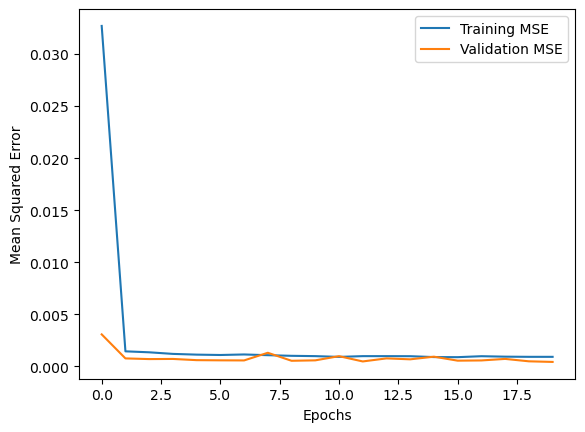

In [66]:
best_train_mse = best_model.history.history["loss"][-1]
best_val_mse = best_model.history.history["val_loss"][-1]
print(f"Best Training MSE: {best_train_mse}")
print(f"Best Validation MSE: {best_val_mse}")

plt.plot(best_model.history.history['loss'], label='Training MSE')
plt.plot(best_model.history.history['val_loss'], label='Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

Processed best model: 'optimizer': 'adam', 'learning_rate': 0.001, 'kernel_regularizer': 'l2', 'batch_size': 16, 'activation': 'tanh'

Raw best model: 'optimizer': 'sgd', 'learning_rate': 0.1, 'kernel_regularizer': None, 'batch_size': 16, 'activation': 'relu'